<a href="https://colab.research.google.com/github/maulanaakbardj/notebook_TG/blob/main/TG2_ML_Movie_rec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyTigerGraph
import pyTigerGraph as tg

In [ ]:
conn = tg.TigerGraphConnection(host="https://mytg.i.tgcloud.io", password="pass123")

In [ ]:
print(conn.gsql('''
CREATE VERTEX Person (PRIMARY_ID id INT) WITH primary_id_as_attribute="true"
CREATE VERTEX Movie (PRIMARY_ID id INT, title STRING, genres STRING) WITH primary_id_as_attribute="true"
CREATE DIRECTED EDGE rate (From Person, To Movie, rating DOUBLE, rated_at DATETIME) WITH REVERSE_EDGE="reverse_rate"
''', options=[]))

Successfully created vertex types: [Person].
Successfully created vertex types: [Movie].
Successfully created edge types: [rate].
Successfully created reverse edge types: [reverse_rate].


In [ ]:
print(conn.gsql('''CREATE GRAPH MovRec(Person, Movie, rate)''', options=[]))

The graph MovRec is created.


In [ ]:
import pandas as pd
from datetime import datetime 
ratings = pd.read_csv("/content/ratings.csv")
movies = pd.read_csv("/content/movies.csv")

In [ ]:
ratings

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580
...,...,...,...,...
12297413,84930,737,1.5,1361289365
12297414,84930,924,4.5,1361289555
12297415,84930,1175,2.5,1361290091
12297416,84930,1196,4.0,1361289743


In [ ]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
27273,131254,Kein Bund für's Leben (2007),Comedy
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy
27275,131258,The Pirates (2014),Adventure
27276,131260,Rentun Ruusu (2001),(no genres listed)


In [ ]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10515485 entries, 0 to 10515484
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 320.9 MB


In [ ]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  27278 non-null  int64 
 1   title    27278 non-null  object
 2   genres   27278 non-null  object
dtypes: int64(1), object(2)
memory usage: 639.5+ KB


In [ ]:
ratings['timestamp'] = [datetime.fromtimestamp(x) for x in ratings['timestamp']]

In [ ]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12297418 entries, 0 to 12297417
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   userId     int64         
 1   movieId    int64         
 2   rating     float64       
 3   timestamp  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 375.3 MB


In [ ]:
ratings

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40
...,...,...,...,...
12297413,84930,737,1.5,2013-02-19 15:56:05
12297414,84930,924,4.5,2013-02-19 15:59:15
12297415,84930,1175,2.5,2013-02-19 16:08:11
12297416,84930,1196,4.0,2013-02-19 16:02:23


In [ ]:
ratings['userId'] = ratings['userId'].astype(int)
ratings['movieId']= ratings['movieId'].astype(int)
ratings['rating']= ratings['rating'].astype(float)
ratings['timestamp']= ratings['timestamp']
movies['movieId'] = movies['movieId'].astype(int)
movies['title']= movies['title'].astype(str)
movies['genres']= movies['genres'].astype(str)

In [ ]:
v_movie = conn.upsertVertexDataFrame(movies, "Movie", "movieId", attributes={"id": "movieId", "title": "title", "genres": "genres"})
e_rate = conn.upsertEdgeDataFrame(ratings, "Person", "rate", "Movie", attributes={"Person": "userId", "Movie": "movieId", "rating": "rating", "rate_at": "timestamp"})
# PRINT OUT STATS
print("=====TOTAL_UPSERTS=====")
print(str(v_movie) + " TOTAL VERTICES")
print(str(e_rate) + " TOTAL EDGES")

In [ ]:
!pip install flat-table
import flat_table
from __future__ import absolute_import, division, print_function, unicode_literals
##importing packages to build model under sklearn framework
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import utils
from sklearn.preprocessing import LabelEncoder

In [ ]:
conn.graphname = "MovRec"
secret = conn.createSecret()
token = conn.getToken(secret, setToken=True)
print(token)

('u1k4q678be1e5kjqk3ukj27ekja5r3kc', 1646950325, '2022-03-10 22:12:05')


In [ ]:
results = conn.getEndpoints()
print(results)

{'DELETE /graph/{graph_name}/delete_by_type/vertices/{vertex_type}/': {'parameters': {'ack': {'default': 'all', 'max_count': 1, 'min_count': 1, 'options': ['all', 'none'], 'type': 'STRING'}, 'graph_name': {'default': '', 'max_count': 1, 'min_count': 0, 'type': 'STRING'}, 'permanent': {'default': False, 'max_count': 1, 'min_count': 1, 'type': 'BOOL'}, 'vertex_type': {'type': 'TYPENAME'}}}, 'DELETE /graph/{graph_name}/edges/{source_vertex_type}/{source_vertex_id}/{edge_type}/{target_vertex_type}/{target_vertex_id}': {'parameters': {'edge_type': {'max_count': 1, 'min_count': 0, 'type': 'EDGETYPENAME'}, 'filter': {'max_count': 1, 'max_length': 2560, 'min_count': 0, 'type': 'STRING'}, 'graph_name': {'default': '', 'max_count': 1, 'min_count': 0, 'type': 'STRING'}, 'limit': {'max_count': 1, 'min_count': 0, 'type': 'UINT64'}, 'not_wildcard': {'max_count': 1, 'min_count': 0, 'type': 'BOOL'}, 'permanent': {'default': False, 'max_count': 1, 'min_count': 1, 'type': 'BOOL'}, 'select': {'max_count'

In [ ]:
conn.gsql('''
USE GRAPH MovRec
DROP QUERY userData
CREATE QUERY userData(VERTEX <Person> p) FOR GRAPH MovRec {
// Feature Extraction of person: movieID, movieTitle, userRating, term, termRating
// Sample Param = 271
SumAccum<float> @rating;
BagAccum<VERTEX> @user;
src = {p}; //From the User
S1 = SELECT tgt FROM src:s -(rate:e)-> Movie:tgt //Grab all the movies that they rated
ACCUM tgt.@rating += e.rating,
tgt.@user += p;
//Also add a local varible of that users rating
PRINT S1[S1.@user as user, S1.title as movieTitle, S1.@rating as userRating, S1.genres as genre];
}
INSTALL QUERY userData
''', options=[])

'Using graph \'MovRec\'\nSemantic Check Fails: These queries could not be found anywhere: [userData].\nSuccessfully created queries: [userData].\nStart installing queries, about 1 minute ...\nuserData query: curl -X GET \'https://127.0.0.1:9000/query/MovRec/userData?p=VALUE\'. Add -H "Authorization: Bearer TOKEN" if authentication is enabled.\nSelect \'m1\' as compile server, now connecting ...\nNode \'m1\' is prepared as compile server.\n\nQuery installation finished.'

In [ ]:
preInstalledResult = conn.runInstalledQuery("userData", {"p":"118205"})
parsR = (preInstalledResult)
print(parsR) # full return of REST call

[{'S1': [{'v_id': '114624', 'v_type': 'Movie', 'attributes': {'user': ['118205'], 'movieTitle': 'Barbary Coast Gent (Gold Town) (Honest Thief, The) (1944)', 'userRating': 3, 'genre': 'Comedy|Western'}}, {'v_id': '114400', 'v_type': 'Movie', 'attributes': {'user': ['118205'], 'movieTitle': 'Chain Lightning (1950)', 'userRating': 3, 'genre': 'Action|Drama'}}, {'v_id': '115409', 'v_type': 'Movie', 'attributes': {'user': ['118205'], 'movieTitle': 'Brothers Rico, The (1957)', 'userRating': 3, 'genre': 'Crime|Drama|Film-Noir|Thriller'}}, {'v_id': '115078', 'v_type': 'Movie', 'attributes': {'user': ['118205'], 'movieTitle': 'Barnacle Bill (1941)', 'userRating': 3.5, 'genre': 'Comedy|Drama'}}, {'v_id': '113325', 'v_type': 'Movie', 'attributes': {'user': ['118205'], 'movieTitle': 'Calling Bulldog Drummond (1951)', 'userRating': 3, 'genre': 'Crime|Mystery'}}, {'v_id': '112710', 'v_type': 'Movie', 'attributes': {'user': ['118205'], 'movieTitle': 'Strange One, The (1957)', 'userRating': 3.5, 'genr

In [ ]:
import pandas as pd
df = pd.DataFrame(parsR[0]["S1"]) # Grab only the data we are returningdf 
df

,v_id,v_type,attributes
0,114624,Movie,"{'user': ['118205'], 'movieTitle': 'Barbary Co..."
1,114400,Movie,"{'user': ['118205'], 'movieTitle': 'Chain Ligh..."
2,115409,Movie,"{'user': ['118205'], 'movieTitle': 'Brothers R..."
3,115078,Movie,"{'user': ['118205'], 'movieTitle': 'Barnacle B..."
4,113325,Movie,"{'user': ['118205'], 'movieTitle': 'Calling Bu..."
...,...,...,...
9249,5961,Movie,"{'user': ['118205'], 'movieTitle': 'Blue Steel..."
9250,110850,Movie,"{'user': ['118205'], 'movieTitle': 'Broadway M..."
9251,64926,Movie,"{'user': ['118205'], 'movieTitle': 'Battle of ..."
9252,1746,Movie,"{'user': ['118205'], 'movieTitle': 'Senseless ..."


In [ ]:
# Normalize Data
# regarded as a preprocessing step
df_t1 = flat_table.normalize(df)
df_t1['attributes.userRating'] = df_t1['attributes.userRating']/5 # divinding by 5 to get a decimal rating which will be used in model
df_t1 # Output DataFrame

,index,v_id,v_type,attributes.genre,attributes.userRating,attributes.movieTitle,attributes.user
0,0,114624,Movie,Comedy|Western,0.6,"Barbary Coast Gent (Gold Town) (Honest Thief, ...",118205
1,1,114400,Movie,Action|Drama,0.6,Chain Lightning (1950),118205
2,2,115409,Movie,Crime|Drama|Film-Noir|Thriller,0.6,"Brothers Rico, The (1957)",118205
3,3,115078,Movie,Comedy|Drama,0.7,Barnacle Bill (1941),118205
4,4,113325,Movie,Crime|Mystery,0.6,Calling Bulldog Drummond (1951),118205
...,...,...,...,...,...,...,...
9249,9249,5961,Movie,Action|Thriller,0.6,Blue Steel (1990),118205
9250,9250,110850,Movie,Musical|Romance,0.7,Broadway Melody of 1938 (1937),118205
9251,9251,64926,Movie,Documentary|War,0.7,"Battle of Russia, The (Why We Fight, 5) (1943)",118205
9252,9252,1746,Movie,Comedy,0.5,Senseless (1998),118205


In [ ]:
# Rename Columns
df_t2 = df_t1.rename(columns={
'attributes.user':'userID',
'v_id':'ID',
'v_type':'Type',
'attributes.movieID':'movieID',
'attributes.movieTitle':'movieTitle',
'attributes.userRating':'userRating',
'attributes.genre':'genre'
})
df_t2 # Output DataFrame

,index,ID,Type,genre,userRating,movieTitle,userID
0,0,114624,Movie,Comedy|Western,0.6,"Barbary Coast Gent (Gold Town) (Honest Thief, ...",118205
1,1,114400,Movie,Action|Drama,0.6,Chain Lightning (1950),118205
2,2,115409,Movie,Crime|Drama|Film-Noir|Thriller,0.6,"Brothers Rico, The (1957)",118205
3,3,115078,Movie,Comedy|Drama,0.7,Barnacle Bill (1941),118205
4,4,113325,Movie,Crime|Mystery,0.6,Calling Bulldog Drummond (1951),118205
...,...,...,...,...,...,...,...
9249,9249,5961,Movie,Action|Thriller,0.6,Blue Steel (1990),118205
9250,9250,110850,Movie,Musical|Romance,0.7,Broadway Melody of 1938 (1937),118205
9251,9251,64926,Movie,Documentary|War,0.7,"Battle of Russia, The (Why We Fight, 5) (1943)",118205
9252,9252,1746,Movie,Comedy,0.5,Senseless (1998),118205


In [ ]:
# Exploding the genre types to seperate rows
data = {'userID': [], 'ID': [],'Type': [], 'movieTitle': [],'genre': [],'userRating': []}
for i in df_t2.index:
  genres = df_t2["genre"][i].split("|")
  for e in genres:
    data['userID'].append(df_t2['userID'][i])
    data["ID"].append(df_t2["ID"][i])
    data["Type"].append(df_t2["Type"][i])
    data["movieTitle"].append(df_t2["movieTitle"][i])
    data["genre"].append(e)
    data["userRating"].append(df_t2["userRating"][i])
df_t2 = pd.DataFrame(data, columns = ['userID','ID','Type','movieTitle','genre', 'userRating'])
print(df_t2)

       userID      ID  ...        genre userRating
0      118205  114624  ...       Comedy        0.6
1      118205  114624  ...      Western        0.6
2      118205  114400  ...       Action        0.6
3      118205  114400  ...        Drama        0.6
4      118205  115409  ...        Crime        0.6
...       ...     ...  ...          ...        ...
19585  118205  110850  ...      Romance        0.7
19586  118205   64926  ...  Documentary        0.7
19587  118205   64926  ...          War        0.7
19588  118205    1746  ...       Comedy        0.5
19589  118205    7572  ...        Drama        0.8

[19590 rows x 6 columns]


In [ ]:
#We will need to extract only with “UserID”, “movieID(ID)” and “userRating” as features
data_others = df_t2[['movieTitle', 'genre', 'ID']]
data_others

,movieTitle,genre,ID
0,"Barbary Coast Gent (Gold Town) (Honest Thief, ...",Comedy,114624
1,"Barbary Coast Gent (Gold Town) (Honest Thief, ...",Western,114624
2,Chain Lightning (1950),Action,114400
3,Chain Lightning (1950),Drama,114400
4,"Brothers Rico, The (1957)",Crime,115409
...,...,...,...
19585,Broadway Melody of 1938 (1937),Romance,110850
19586,"Battle of Russia, The (Why We Fight, 5) (1943)",Documentary,64926
19587,"Battle of Russia, The (Why We Fight, 5) (1943)",War,64926
19588,Senseless (1998),Comedy,1746


In [ ]:
## UserRating extraction
data_target = df_t2[['userRating']]
data_target

,userRating
0,0.6
1,0.6
2,0.6
3,0.6
4,0.6
...,...
19585,0.7
19586,0.7
19587,0.7
19588,0.5


In [ ]:
##transformation for “genre” column
enconder = LabelEncoder()
genre_label = enconder.fit_transform(data_others['genre'])
genre_mappings = {index: label for index, label in
enumerate(enconder.classes_)}
genre_mappings

{0: '01 - September 11 (2002)",Drama',
 1: 'Action',
 2: 'Adventure',
 3: 'Animation',
 4: 'Children',
 5: 'Comedy',
 6: 'Crime',
 7: 'Documentary',
 8: 'Drama',
 9: 'Fantasy',
 10: 'Film-Noir',
 11: 'Great Performances"" Cats (1998)',
 12: 'Horror',
 13: 'IMAX',
 14: 'Musical',
 15: 'Mystery',
 16: 'Romance',
 17: 'Sci-Fi',
 18: 'Thriller',
 19: 'War',
 20: 'Western'}

In [ ]:
##transformation for “movieTitle”
movie_title = enconder.fit_transform(data_others['movieTitle'])
movietitle_mappings = {index: label for index, label in
enumerate(enconder.classes_)}
movietitle_mappings

{0: '"Great Performances" Cats (1998)',
 1: '#chicagoGirl: The Social Network Takes on a Dictator (2013)',
 2: '$ (Dollars) (1971)',
 3: "'Neath the Arizona Skies (1934)",
 4: "'Round Midnight (1986)",
 5: "'Twas the Night Before Christmas (1974)",
 6: "'burbs, The (1989)",
 7: '(500) Days of Summer (2009)',
 8: '*batteries not included (1987)',
 9: '...All the Marbles (California Dolls, The) (1981)',
 10: '...And Justice for All (1979)',
 11: '10 (1979)',
 12: '10 Rillington Place (1971)',
 13: '10 Things I Hate About You (1999)',
 14: '10 to Midnight (1983)',
 15: '100 Girls (2000)',
 16: '100 Men and a Girl (One Hundred Men and a Girl) (1937)',
 17: '100 Rifles (1969)',
 18: '1000 Eyes of Dr. Mabuse, The (Die 1000 Augen des Dr. Mabuse) (1960)',
 19: '101 Dalmatians (1996)',
 20: '101 Dalmatians (One Hundred and One Dalmatians) (1961)',
 21: '101 Reykjavik (101 Reykjavík) (2000)',
 22: '102 Dalmatians (2000)',
 23: '10th & Wolf (2006)',
 24: '11 Harrowhouse (1974)',
 25: "11'09",
 26

In [ ]:
## data transformation
data_others['genre_label'] = genre_label
data_others['movie_title'] = movie_title

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
## dataset merge
features = data_others[['genre_label','movie_title']].copy()
features

,genre_label,movie_title
0,5,727
1,20,727
2,1,1588
3,8,1588
4,6,1353
...,...,...
19585,16,1319
19586,7,774
19587,19,774
19588,5,7258


In [ ]:
##data separation
Xtrain, Xtest, Ytrain, Ytest = train_test_split(features, data_target, test_size=0.3)

In [ ]:
## data validation
Xval, Xtest, Yval, Ytest = train_test_split(Xtest, Ytest, test_size=0.6, random_state=40)

In [ ]:
##model building for random forest
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(max_depth=20, random_state=0)
rf_model.fit(Xtrain, Ytrain)
y_pred = rf_model.predict(Xtest)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


In [ ]:
##model evaluation through MSE and RMSE
from sklearn import metrics
import numpy as np
print('Mean Squared Error:', metrics.mean_squared_error(Ytest, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Ytest, y_pred)))


Mean Squared Error: 0.012050811453966807
Root Mean Squared Error: 0.10977618800981753


In [ ]:
df_t3 = df_t2.pivot(index='ID', columns='genre', values='userRating')
df_t3 = pd.DataFrame(df_t3, columns = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])
df_t3 = df_t3.fillna(0)
df_t3 # Output DataFrame

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
ID,,,,,,,,,,,,,,,,,,,
1,0.0,0.8,0.8,0.8,0.8,0.0,0.0,0.0,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.8,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.8,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6,0.0,0.0
100042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6,0.6
100165,0.0,0.6,0.0,0.0,0.0,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99871,0.0,0.0,0.0,0.0,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6,0.0,0.0,0.0,0.0,0.0
99873,0.0,0.0,0.0,0.0,0.0,0.6,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99875,0.0,0.0,0.0,0.0,0.0,0.6,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Put dataframes together
df_t4 = pd.merge(df_t2, df_t3, how='outer', on=['ID'])
df_t5 = df_t4.drop(columns=['genre'])
df_t6 = df_t5.drop_duplicates(subset ="ID")
df_t6 # Output DataFrame

,userID,ID,Type,movieTitle,userRating,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,118205,114624,Movie,"Barbary Coast Gent (Gold Town) (Honest Thief, ...",0.6,0.0,0.0,0.0,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6
2,118205,114400,Movie,Chain Lightning (1950),0.6,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,118205,115409,Movie,"Brothers Rico, The (1957)",0.6,0.0,0.0,0.0,0.0,0.0,0.6,0.0,0.6,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.6,0.0,0.0
8,118205,115078,Movie,Barnacle Bill (1941),0.7,0.0,0.0,0.0,0.0,0.7,0.0,0.0,0.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,118205,113325,Movie,Calling Bulldog Drummond (1951),0.6,0.0,0.0,0.0,0.0,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19582,118205,5961,Movie,Blue Steel (1990),0.6,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6,0.0,0.0
19584,118205,110850,Movie,Broadway Melody of 1938 (1937),0.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7,0.0,0.7,0.0,0.0,0.0,0.0
19586,118205,64926,Movie,"Battle of Russia, The (Why We Fight, 5) (1943)",0.7,0.0,0.0,0.0,0.0,0.0,0.0,0.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7,0.0
19588,118205,1746,Movie,Senseless (1998),0.5,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Features to grab
features = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

In [ ]:
!pip install tensorflow
# Setting up your data for TensorFlow
import tensorflow as tf
dataset = (
            tf.data.Dataset.from_tensor_slices(
            (tf.cast(df_t6[features].values, tf.float64),
            tf.cast(df_t6['userRating'].values, tf.float64)
            ))
          )
tf.keras.backend.set_floatx('float64')

In [ ]:
# Checking Data
for feat, targ in dataset.take(10):
  print('Features: {}, Target: {}'.format(feat, targ))

Features: [0.  0.  0.  0.  0.6 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.6], Target: 0.6
Features: [0.6 0.  0.  0.  0.  0.  0.  0.6 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0. ], Target: 0.6
Features: [0.  0.  0.  0.  0.  0.6 0.  0.6 0.  0.6 0.  0.  0.  0.  0.  0.  0.6 0.
 0. ], Target: 0.6
Features: [0.  0.  0.  0.  0.7 0.  0.  0.7 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0. ], Target: 0.7
Features: [0.  0.  0.  0.  0.  0.6 0.  0.  0.  0.  0.  0.  0.  0.6 0.  0.  0.  0.
 0. ], Target: 0.6
Features: [0.  0.  0.  0.  0.  0.  0.  0.7 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0. ], Target: 0.7
Features: [0.  0.  0.  0.  0.  0.  0.  0.6 0.  0.  0.  0.  0.6 0.  0.6 0.  0.  0.
 0. ], Target: 0.6
Features: [0.  0.  0.  0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0. ], Target: 0.5
Features: [0.  0.  0.  0.  0.6 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.6 0.  0.  0.
 0. ], Target: 0.6
Features: [0.  0.  0.  0.  0.  0.6 0.  0.6 0.  0.6 0.  0.  0.  0.  0.  0.  0.  0.
 0. ], Ta

In [ ]:
tf.constant(df_t6['userRating'])

<tf.Tensor: shape=(9254,), dtype=float64, numpy=array([0.6, 0.6, 0.6, ..., 0.7, 0.5, 0.8])>

In [ ]:
# Prep datasets, one for model creation, other for model validation
dataset = dataset.shuffle(len(df_t6)).batch(1)
train_dataset = dataset.take(int(len(df_t6)*.8))
test_dataset = dataset.skip(int(len(df_t6)*.8))
print(len(list(train_dataset)))

7403


In [ ]:
def get_compiled_model():
  model = tf.keras.Sequential([tf.keras.layers.Dense(8, activation='relu'), #layer 1
                               tf.keras.layers.Dense(1, activation='sigmoid') #out
                              ])
  # training operations for optimization, loss and metrics
  model.compile(optimizer='adam',
                loss='mean_squared_error',
                metrics=['mean_absolute_error'])
  return model

In [ ]:
# Training Data
model = get_compiled_model()
model.fit(train_dataset, epochs=20)

Epoch 1/20
7403/7403 [==============================] - 21s 3ms/step - loss: 0.0073 - mean_absolute_error: 0.0683
Epoch 2/20
7403/7403 [==============================] - 18s 2ms/step - loss: 0.0048 - mean_absolute_error: 0.0540
Epoch 3/20
7403/7403 [==============================] - 16s 2ms/step - loss: 0.0034 - mean_absolute_error: 0.0435
Epoch 4/20
7403/7403 [==============================] - 18s 2ms/step - loss: 0.0026 - mean_absolute_error: 0.0357
Epoch 5/20
7403/7403 [==============================] - 18s 2ms/step - loss: 0.0021 - mean_absolute_error: 0.0304
Epoch 6/20
7403/7403 [==============================] - 15s 2ms/step - loss: 0.0017 - mean_absolute_error: 0.0261
Epoch 7/20
7403/7403 [==============================] - 10s 1ms/step - loss: 0.0015 - mean_absolute_error: 0.0238
Epoch 8/20
7403/7403 [==============================] - 11s 1ms/step - loss: 0.0014 - mean_absolute_error: 0.0228
Epoch 9/20
7403/7403 [==============================] - 11s 1ms/step - loss: 0.0013 - me

In [ ]:
results = model.evaluate(test_dataset)

1851/1851 [==============================] - 4s 2ms/step - loss: 0.0010 - mean_absolute_error: 0.0183


In [ ]:
##implement with Gradient Descent Optimizer
##set up the learning rate as 0.02
tf.compat.v1.train.GradientDescentOptimizer(
    learning_rate = 0.02, use_locking=False, name='GradientDescent'
    )

In [ ]:
model_version1 = model.fit( train_dataset,
                            batch_size = 80,
                            epochs = 20,
                            validation_freq = 20,)

Epoch 1/20
7403/7403 [==============================] - 13s 2ms/step - loss: 0.0010 - mean_absolute_error: 0.0191
Epoch 2/20
7403/7403 [==============================] - 14s 2ms/step - loss: 0.0010 - mean_absolute_error: 0.0189
Epoch 3/20
7403/7403 [==============================] - 18s 2ms/step - loss: 9.5899e-04 - mean_absolute_error: 0.0183
Epoch 4/20
7403/7403 [==============================] - 11s 1ms/step - loss: 9.7493e-04 - mean_absolute_error: 0.0184
Epoch 5/20
7403/7403 [==============================] - 11s 1ms/step - loss: 9.0054e-04 - mean_absolute_error: 0.0181
Epoch 6/20
7403/7403 [==============================] - 11s 1ms/step - loss: 9.4146e-04 - mean_absolute_error: 0.0180
Epoch 7/20
7403/7403 [==============================] - 11s 1ms/step - loss: 9.4502e-04 - mean_absolute_error: 0.0179
Epoch 8/20
7403/7403 [==============================] - 11s 1ms/step - loss: 9.2830e-04 - mean_absolute_error: 0.0176
Epoch 9/20
7403/7403 [==============================] - 10s 1ms/

In [ ]:
#model result after optimization
#the lower loss and the lower mean_absolute error, the better prediction for the model
result_version1 = model.evaluate(test_dataset)

1851/1851 [==============================] - 7s 4ms/step - loss: 7.0522e-04 - mean_absolute_error: 0.0139


In [ ]:
target_v = df_t6['userRating']
non_target = df_t2[['genre', 'movieTitle']]

In [ ]:
target_v

0        0.6
2        0.6
4        0.6
8        0.7
10       0.6
        ... 
19582    0.6
19584    0.7
19586    0.7
19588    0.5
19589    0.8
Name: userRating, Length: 9254, dtype: float64

In [ ]:
non_target

,genre,movieTitle
0,Comedy,"Barbary Coast Gent (Gold Town) (Honest Thief, ..."
1,Western,"Barbary Coast Gent (Gold Town) (Honest Thief, ..."
2,Action,Chain Lightning (1950)
3,Drama,Chain Lightning (1950)
4,Crime,"Brothers Rico, The (1957)"
...,...,...
19585,Romance,Broadway Melody of 1938 (1937)
19586,Documentary,"Battle of Russia, The (Why We Fight, 5) (1943)"
19587,War,"Battle of Russia, The (Why We Fight, 5) (1943)"
19588,Comedy,Senseless (1998)


In [ ]:
three_target = df_t2[['genre', 'movieTitle','userRating']]
three_target

,genre,movieTitle,userRating
0,Comedy,"Barbary Coast Gent (Gold Town) (Honest Thief, ...",0.6
1,Western,"Barbary Coast Gent (Gold Town) (Honest Thief, ...",0.6
2,Action,Chain Lightning (1950),0.6
3,Drama,Chain Lightning (1950),0.6
4,Crime,"Brothers Rico, The (1957)",0.6
...,...,...,...
19585,Romance,Broadway Melody of 1938 (1937),0.7
19586,Documentary,"Battle of Russia, The (Why We Fight, 5) (1943)",0.7
19587,War,"Battle of Russia, The (Why We Fight, 5) (1943)",0.7
19588,Comedy,Senseless (1998),0.5


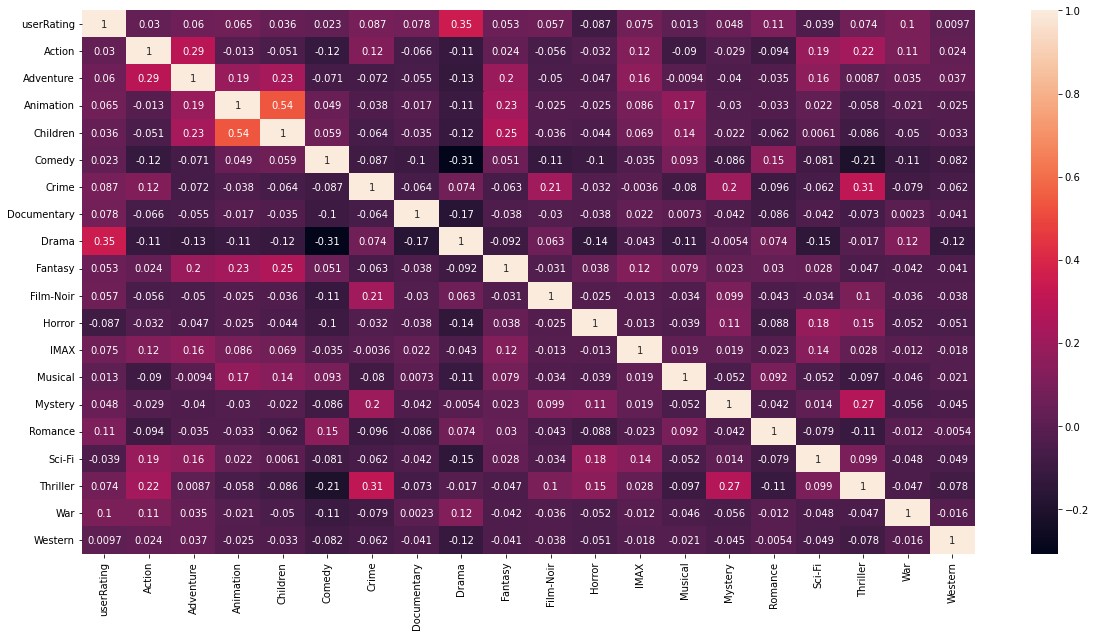

In [ ]:
##feature selection through correlation coefficient
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
cor = df_t6.corr()
plt.figure(figsize = (20,10))
sns.heatmap(cor, annot=True)